# Experiment 3a: Steering at Thought Anchors (KL vs. beta)

This notebook loads:
- an annotated example with a thought anchor,
- the corresponding steering vector computed in `experiments/find_steering_vectors.py`,

and measures how the next-token distribution changes when we steer activations
at the layer and position just before the anchor sentence. We sweep steering amplitude
`beta` in [-1, 1] and compute KL divergence vs. the unsteered baseline.

In [1]:
import os, json, math
from typing import List, Dict

import torch
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
from utils import load_model_and_vectors, split_solution_into_chunks

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

/opt/conda/envs/anchorsteering/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
# Config
model_name = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B'
model_tag = model_name.replace('/', '-')
from pathlib import Path
# Find repo root by searching upwards for 'generated_data' (fallback: cwd)
repo_root = Path.cwd().resolve().parents[0] if (Path.cwd()).exists() else Path.cwd().resolve()
# Build absolute paths to the generated_data files
annotated_path = repo_root / 'generated_data' / f'generated_data_annotated_{model_tag}.json'
vectors_path = repo_root / 'generated_data' / f'steering_vectors_{model_tag}.json'
anchors_path = repo_root / 'generated_data' / f'steering_anchors_{model_tag}.json'
example_index = 0  # change to pick a different example

# Steering amplitudes to test
betas = np.linspace(-10, 10, 21)  # [-1, ..., 1]
betas

array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [3]:
# Load model/tokenizer
model, tokenizer, _ = load_model_and_vectors(model_name=model_name, compute_features=False, device=device)
model.model.eval()

# Load data
with open(annotated_path, 'r') as f:
    annotated = json.load(f)
with open(anchors_path, 'r') as f:
    anchors_payload = json.load(f)
len(annotated), len(anchors_payload.get('examples', []))


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


No mean vectors found for deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B. You can save to generated_data/mean_vectors_deepseek-r1-distill-qwen-1.5b.pt.


(2, 2)

In [4]:
# Select example and load per-chunk steering vectors
ex = None
if example_index < len(annotated):
    ex = annotated[example_index]
else:
    ex = annotated[0]

question = ex['prompt']
cot = ex['cot']
anchor_idx = ex.get('thought_anchor_idx', None)
anchor_sentence = ex.get('thought_anchor_sentence', '')

# Load chunk vectors for the matching example from anchors payload
examples_anchors = anchors_payload.get('examples', [])
vi = min(example_index, len(examples_anchors)-1) if examples_anchors else 0
anchors_ex = examples_anchors[vi] if examples_anchors else {}
layer_idx = anchors_ex.get('layer', model.config.num_hidden_layers - 1)

# Build a mapping: chunk_index -> vector tensor
chunk_vectors = {}
for ch in anchors_ex.get('chunks', []):
    vec = torch.tensor(ch.get('vector', []), dtype=(torch.bfloat16 if model.model.dtype==torch.bfloat16 else torch.float32), device=device)
    chunk_vectors[int(ch.get('chunk_index', 0))] = vec

# Default steer_vector: use the anchor's chunk vector if present, else chunk 0
steer_vector = chunk_vectors.get(int(anchor_idx) if anchor_idx is not None else 0, next(iter(chunk_vectors.values()), torch.zeros(model.config.hidden_size, dtype=torch.float32, device=device)))
len(chunk_vectors), layer_idx, anchor_idx, anchor_sentence[:80] + ('...' if len(anchor_sentence)>80 else '')

(24,
 24,
 0,
 'Okay, so I have this problem to solve: evaluate the product of four cube roots m...')

In [5]:
# Build the prefix up to (but not including) the anchor sentence
chunks = split_solution_into_chunks(cot)
if anchor_idx is None or anchor_idx < 0 or anchor_idx >= len(chunks):
    # fallback: find sentence match
    try:
        anchor_idx = next((i for i,s in enumerate(chunks) if s.strip()==anchor_sentence.strip()), 0)
    except Exception:
        anchor_idx = 0
prefix_text = '\n'.join(chunks[:anchor_idx])

prompt = (
    "Solve the following problem step by step. You MUST put your final answer in \\boxed{}.\n\n"
    f"Problem: {question}\n\n"
    f"Solution:\n<think>\n{prefix_text}"
)
ids = tokenizer(prompt, return_tensors='pt')
input_ids = ids['input_ids'].to(device)
pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else (tokenizer.eos_token_id or 0)
attention_mask = (input_ids != pad_id).long().to(device)
input_ids.shape, attention_mask.shape, input_ids[0, -5:]

(torch.Size([1, 64]),
 torch.Size([1, 64]),
 tensor([   382,  36842,    510, 151648,    198], device='cuda:0'))

In [6]:
@torch.no_grad()
def _forward_with_logits(input_ids, attention_mask):
    # Try to get logits; if the called path returns only hidden states, project via lm_head
    outputs = model.model(input_ids=input_ids, attention_mask=attention_mask, use_cache=False, output_hidden_states=True, return_dict=True)
    logits = getattr(outputs, 'logits', None)
    if logits is None:
        last_hidden = outputs.last_hidden_state if hasattr(outputs, 'last_hidden_state') else outputs[0]
        # Resolve the lm_head either on the top-level or on the causal LM module
        head_owner = model if hasattr(model, 'lm_head') else (model.model if hasattr(model.model, 'lm_head') else None)
        if head_owner is None:
            raise AttributeError('Could not find lm_head on model or model.model')
        logits = head_owner.lm_head(last_hidden)
    return logits

In [7]:
# Measurement mode toggle
teacher_forced_mode = True  # compare logits at same positions (teacher-forced)

In [8]:
# Generalized helpers to steer arbitrary chunk prefixes (RMS-scaled beta, per-chunk vectors)
@torch.no_grad()
def logits_with_steer_for(prefix_ids: torch.Tensor, attn_mask: torch.Tensor, beta: float):
    # Apply steering at target layer for the last position of prefix_ids, scaling by RMS
    backbone = getattr(model.model, 'model', model.model)
    target = backbone.layers[layer_idx]
    # Use global steer_vector set for current chunk
    d = steer_vector.detach().to(torch.float32)
    d = d / (d.norm() + 1e-12)
    def hook(module, inputs, output):
        out = output
        try:
            if isinstance(out, tuple):
                h = out[0].clone()
                rest = out[1:]
            else:
                h = out.clone()
                rest = tuple()
            h_last_fp32 = h[:, -1:, :].to(torch.float32)
            rms = torch.sqrt(torch.mean(h_last_fp32 ** 2) + 1e-20)
            delta_fp32 = (float(beta) * rms) * d.view(1, 1, -1)
            h[:, -1:, :] = (h_last_fp32 + delta_fp32).to(h.dtype)
            return (h,) + rest if isinstance(out, tuple) else h
        except Exception:
            return output
    handle = target.register_forward_hook(hook)
    try:
        logits = _forward_with_logits(prefix_ids, attn_mask)
        return logits[:, -1, :]
    finally:
        handle.remove()

@torch.no_grad()
def kl_curve_for_chunk(chunk_idx: int, betas: np.ndarray):
    """
    For the given chunk index, compare base distributions with steered ones.
    If teacher_forced_mode is True, both base and steered logits are computed on the same token positions (teacher-forced).
    Otherwise, run a free-running rollout. Uses the chunk's own steering vector.
    """
    global steer_vector
    # Set the steer_vector for this chunk (default to chunk 0 if missing)
    if chunk_idx in chunk_vectors:
        steer_vector = chunk_vectors[chunk_idx]
    else:
        if 0 in chunk_vectors:
            steer_vector = chunk_vectors[0]
        else:
            # No vectors available; return zeros
            return [0.0 for _ in betas]

    # Build prefix up to the chunk and get the exact chunk tokens
    prefix_text = ''.join(chunks[:chunk_idx])
    chunk_text = chunks[chunk_idx]
    chunk_ids = tokenizer(chunk_text, return_tensors='pt', add_special_tokens=False)['input_ids']  # [1, T]
    n_steps = int(chunk_ids.shape[-1])

    prompt_prefix = (
        'Solve the following problem step by step. You MUST put your final answer in \boxed{}.\n\n'
        + f'Problem: {question}\n\n'
        + 'Solution:\n<think>\n'
        + prefix_text
    )
    # Encode prefix and full (prefix + original chunk text) to align base logits via a single forward
    enc_prefix = tokenizer(prompt_prefix, return_tensors='pt')
    ids_pref = enc_prefix['input_ids'].to(device)
    pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else (tokenizer.eos_token_id or 0)
    am_pref = (ids_pref != pad_id).long().to(device)

    full_text = prompt_prefix + chunk_text
    enc_full = tokenizer(full_text, return_tensors='pt')
    ids_full = enc_full['input_ids'].to(device)
    am_full = (ids_full != pad_id).long().to(device)

    # Align chunk within full sequence
    full_ids = ids_full[0].tolist()
    chunk_seq = tokenizer(chunk_text, return_tensors='pt', add_special_tokens=False)['input_ids'][0].tolist()
    s_idx = -1
    for pos in range(max(0, ids_pref.shape[-1]-4), len(full_ids)-len(chunk_seq)+1):
        if full_ids[pos:pos+len(chunk_seq)] == chunk_seq:
            s_idx = pos
            break
    if s_idx == -1:
        s_idx = int(ids_pref.shape[-1])
    # start index points to position that predicts first chunk token (the previous position)
    start = max(0, s_idx - 1)
    logits_full = _forward_with_logits(ids_full, am_full)  # [1, L, V]
    seq_len = int(logits_full.shape[1])
    n_eff = max(0, min(n_steps, seq_len - start))
    base_steps = logits_full[:, start:start + n_eff, :]
    base_avg = base_steps.mean(dim=1)  # [1,V]

    def kl_from_logits(avg_logits_p, avg_logits_q):
        logp = torch.log_softmax(avg_logits_p, dim=-1)
        logq = torch.log_softmax(avg_logits_q, dim=-1)
        p = torch.exp(logp)
        return torch.sum(p * (logp - logq), dim=-1)

    curve = []

    if teacher_forced_mode:
        # Same-position comparison: steer at the token just before the chunk (start)
        for b in betas:
            if abs(b) < 1e-12:
                curve.append(0.0)
                continue
            steered_logits = logits_with_steer_full(ids_full, am_full, float(b), start)
            steered_span = steered_logits[:, start:start + n_eff, :]
            base_span = logits_full[:, start:start + n_eff, :]
            # Average KL across the span positions
            kl_t = kl_from_logits(steered_span.reshape(-1, steered_span.shape[-1]), base_span.reshape(-1, base_span.shape[-1]))
            curve.append(float(kl_t.mean().item()))
        return curve

    # Free-running rollout
    for b in betas:
        if abs(b) < 1e-12:
            curve.append(0.0)
            continue
        logs = []
        pf = ids_pref.clone(); amf = am_pref.clone()
        for k in range(n_steps):
            l = logits_with_steer_for(pf, amf, float(b))
            logs.append(l.detach().to(torch.float32))
            next_id = torch.argmax(l, dim=-1)
            pf = torch.cat([pf, next_id.unsqueeze(0)], dim=1)
            amf = torch.cat([amf, torch.ones_like(next_id).unsqueeze(0)], dim=1)
        steered_avg = torch.stack(logs, dim=0).mean(dim=0)
        kl = kl_from_logits(steered_avg, base_avg)
        curve.append(float(kl.item()))
    return curve

@torch.no_grad()
def logits_with_steer_full(input_ids: torch.Tensor, attention_mask: torch.Tensor, beta: float, target_pos: int):
    """Run a full forward pass with a steering delta applied at a specific token index in the chosen layer.
    The perturbation is applied at the token that predicts the next token at target_pos+1. Scales by RMS.
    """
    backbone = getattr(model.model, 'model', model.model)
    target = backbone.layers[layer_idx]
    d = steer_vector.detach().to(torch.float32)
    d = d / (d.norm() + 1e-12)
    def hook(module, inputs, output):
        out = output
        try:
            if isinstance(out, tuple):
                h = out[0].clone(); rest = out[1:]
            else:
                h = out.clone(); rest = tuple()
            pos = int(target_pos)
            if pos < 0 or pos >= h.shape[1]:
                return output
            h_slice_fp32 = h[:, pos:pos+1, :].to(torch.float32)
            rms = torch.sqrt(torch.mean(h_slice_fp32 ** 2) + 1e-20)
            delta_fp32 = (float(beta) * rms) * d.view(1, 1, -1)
            h[:, pos:pos+1, :] = (h_slice_fp32 + delta_fp32).to(h.dtype)
            return (h,) + rest if isinstance(out, tuple) else h
        except Exception:
            return output
    handle = target.register_forward_hook(hook)
    try:
        return _forward_with_logits(input_ids, attention_mask)
    finally:
        handle.remove()

In [9]:
# Compute KL for the anchor using the exact same implementation as the per-chunk routine
# This calls kl_curve_for_chunk which conditions the base logits on the ground-truth chunk
# and performs the identical free-running steered rollout used for other chunks.
kl_values = kl_curve_for_chunk(anchor_idx, betas)
kl_values

[0.00058746337890625,
 0.0004119873046875,
 0.00020122528076171875,
 0.00022792816162109375,
 7.05718994140625e-05,
 0.00021076202392578125,
 0.000209808349609375,
 0.000244140625,
 0.0002574920654296875,
 0.0001373291015625,
 0.0,
 0.0003070831298828125,
 0.00019359588623046875,
 0.00012683868408203125,
 8.20159912109375e-05,
 0.00011348724365234375,
 0.00019931793212890625,
 0.0002117156982421875,
 0.0003662109375,
 0.0003337860107421875,
 0.00064849853515625]

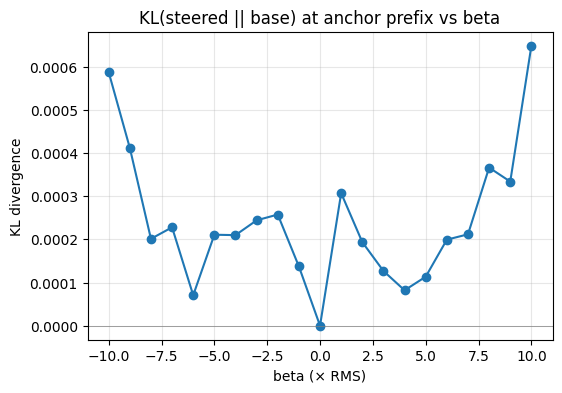

In [10]:
plt.figure(figsize=(6,4))
plt.plot(betas, kl_values, marker='o')
plt.axhline(0, color='gray', lw=0.5)
plt.title('KL(steered || base) at anchor prefix vs beta')
plt.xlabel('beta (× RMS)')
plt.ylabel('KL divergence')
plt.grid(True, alpha=0.3)
plt.show()


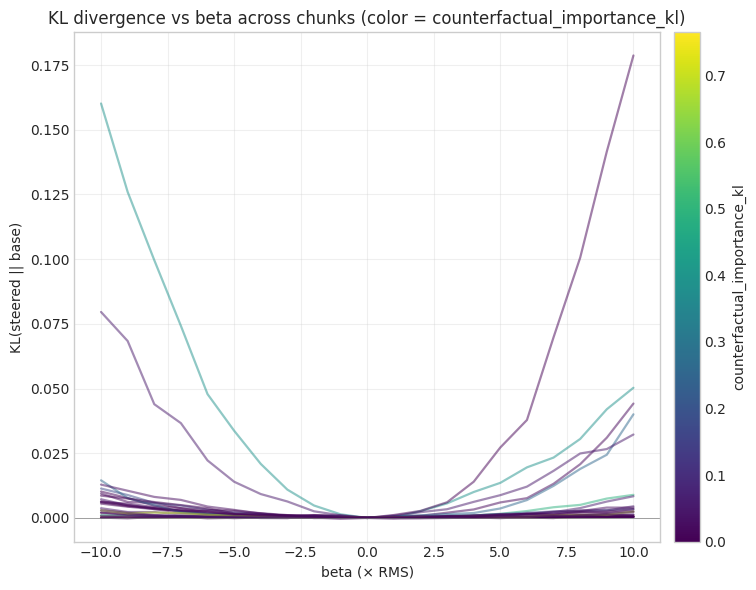

In [11]:
# Compute KL curves for all chunks and plot, color-coded by counterfactual_importance_kl with a colorbar
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import viridis
plt.style.use('seaborn-v0_8-whitegrid')

# Ensure kl_curves exists and has entries
kl_curves = {} if 'kl_curves' not in globals() else kl_curves
if not kl_curves:
    kl_curves = {}
    for idx in range(len(chunks)):
        kl_curves[idx] = kl_curve_for_chunk(idx, betas)

# Build importance array aligned to chunk indices (use 0.0 when missing)
raw_imps = []
for i in range(len(chunks)):
    try:
        raw_imps.append(float(ex['counterfactual_importance_kl'][i]))
    except Exception:
        raw_imps.append(0.0)
imps = np.array(raw_imps, dtype=float)

# Normalizer and colormap
imp_min = float(np.nanmin(imps)) if imps.size>0 else 0.0
imp_max = float(np.nanmax(imps)) if imps.size>0 else 1.0
if imp_max <= imp_min:
    imp_max = imp_min + 1e-6
norm = Normalize(vmin=imp_min, vmax=imp_max)
cmap = plt.cm.viridis

# Plot each chunk's KL curve colored by its importance
fig, ax = plt.subplots(figsize=(8,6))
for idx in sorted(kl_curves.keys()):
    vals = kl_curves[idx]
    if vals is None or len(vals)==0:
        continue
    ys = np.array(vals, dtype=float)
    # If lengths mismatch, trim/pad to betas length
    n = min(len(ys), len(betas))
    xs = np.array(betas)[:n]
    ys = ys[:n]
    col = cmap(norm(imps[idx] if idx < len(imps) else 0.0))
    lw = 1.6  # 2.8 if idx == anchor_idx else 1.6
    alpha = 0.5  # = 0.95 if idx == anchor_idx else 0.6
    ax.plot(xs, ys, color=col, linewidth=lw, alpha=alpha)

# Colorbar mapped to counterfactual_importance_kl
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(imps)
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('counterfactual_importance_kl')

# Labels and styling
ax.axhline(0, color='gray', lw=0.5)
ax.set_xlabel('beta (× RMS)')
ax.set_ylabel('KL(steered || base)')
ax.set_title('KL divergence vs beta across chunks (color = counterfactual_importance_kl)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

n_points=24, spearman_rho=0.196317725795114, pval=0.3578834060097139, slope=8.04303110755331e-05, intercept=0.00014251664732918632


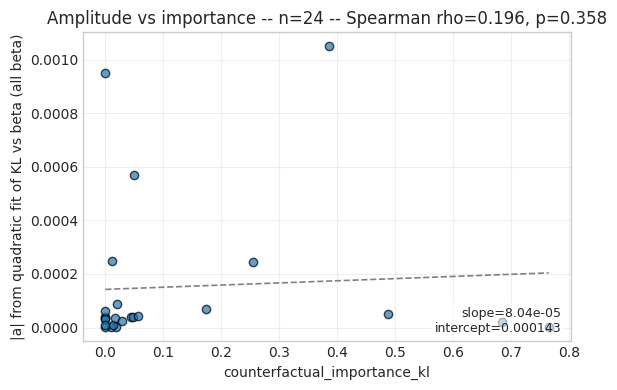

In [12]:

# Fit a quadratic to each KL curve (all beta) and plot the fitted amplitude vs counterfactual_importance_kl
import numpy as np
import matplotlib.pyplot as plt
# Try SciPy for Spearman; fallback to rank+pearson if not available
try:
    from scipy.stats import spearmanr
    _have_scipy = True
except Exception:
    _have_scipy = False

eps_floats = np.array([float(e) for e in betas])
amplitudes = []
importances = []
for idx in range(len(chunks)):
    curve = kl_curves.get(idx, None)
    if curve is None or len(curve) == 0:
        continue
    ys = np.array(curve, dtype=float)
    n = min(len(ys), len(eps_floats))
    x = eps_floats[:n]
    y = ys[:n]
    # Need at least 3 points to fit a quadratic robustly
    if x.size < 3 or np.all(np.isnan(y)):
        continue
    try:
        coeffs = np.polyfit(x, y, 2)  # returns [a, b, c]
        a = float(coeffs[0])
        amp = float(np.abs(a))
    except Exception:
        continue
    amplitudes.append(amp)
    # safe importance retrieval (fallback 0.0)
    try:
        imp = float(ex.get('counterfactual_importance_kl', [0.0]*len(chunks))[idx])
    except Exception:
        imp = 0.0
    importances.append(imp)

# Convert to arrays for plotting/statistics
x = np.array(importances)
y = np.array(amplitudes)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x, y, edgecolor='black', alpha=0.7)
ax.set_xlabel('counterfactual_importance_kl')
ax.set_ylabel('|a| from quadratic fit of KL vs beta (all beta)')

# Compute Spearman if available and meaningful
rho, pval = np.nan, np.nan
n_points = x.size
if n_points > 1:
    if _have_scipy:
        try:
            rho, pval = spearmanr(x, y)
        except Exception:
            rho, pval = np.nan, np.nan
    else:
        # fallback: compute ranks and Pearson on ranks
        def _ranks(arr):
            order = np.argsort(arr)
            ranks = np.empty_like(order, dtype=float)
            ranks[order] = np.arange(len(arr), dtype=float)
            return ranks
        try:
            rx = _ranks(x)
            ry = _ranks(y)
            if np.nanstd(rx) == 0 or np.nanstd(ry) == 0:
                rho, pval = np.nan, np.nan
            else:
                rho = float(np.corrcoef(rx, ry)[0,1])
                pval = np.nan
        except Exception:
            rho, pval = np.nan, np.nan

# Best-fit linear regression on (importance -> amplitude) for visualization
slope, intercept = np.nan, np.nan
if n_points > 1 and not np.allclose(x, x[0]):
    try:
        slope, intercept = np.polyfit(x, y, 1)
        xs_line = np.linspace(np.nanmin(x), np.nanmax(x), 200)
        ys_line = slope * xs_line + intercept
        ax.plot(xs_line, ys_line, color='gray', linestyle='--', linewidth=1.2, label=f'best-fit (slope={slope:.3g})')
    except Exception:
        slope, intercept = np.nan, np.nan

# Title and annotation
title = f'Amplitude vs importance -- n={n_points} -- Spearman rho={np.nan if np.isnan(rho) else float(rho):.3f}'
if not np.isnan(pval):
    title += f', p={float(pval):.3g}'
ax.set_title(title)
# Put fit stats on the plot
ann_lines = []
if not np.isnan(slope):
    ann_lines.append(f'slope={slope:.3g}')
if not np.isnan(intercept):
    ann_lines.append(f'intercept={intercept:.3g}')
if ann_lines:
    ax.text(0.98, 0.02, '\n'.join(ann_lines), transform=ax.transAxes, ha='right', va='bottom', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.6, edgecolor='none'))

# Print summary stats to the output as well
print(f'n_points={n_points}, spearman_rho={rho}, pval={pval}, slope={slope}, intercept={intercept}')

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Centered Steering: Chunk − Mean(Others)

We now steer using a centered direction for each chunk: v_i = unit( z_i − mean_{j≠i} z_j ),
where z_i is the per-chunk mean activation vector from `steering_anchors`.
This removes the global common component across chunks and may sharpen cluster-specific effects.


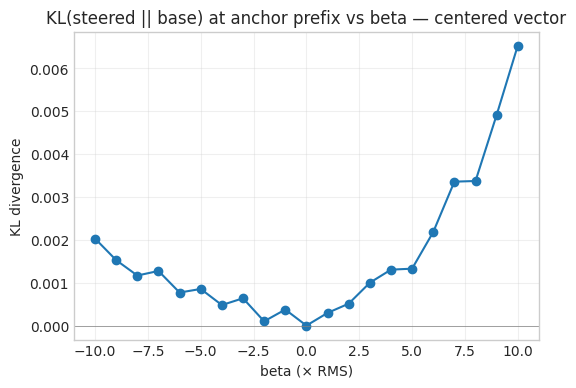

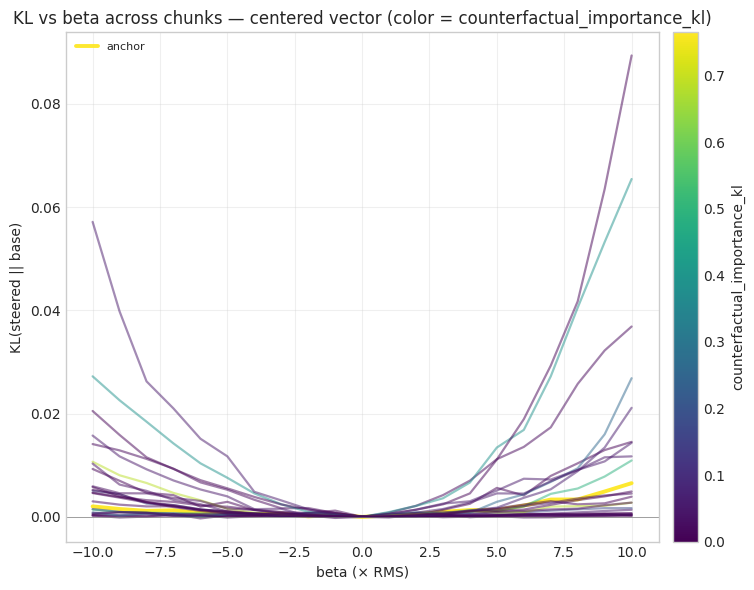

In [13]:
# Build centered (difference) vectors per chunk: v_i = unit(z_i − mean_{j≠i} z_j)
diff_chunk_vectors = {}
all_idxs = sorted(chunk_vectors.keys())
all_vecs = {i: chunk_vectors[i].detach().to(torch.float32) for i in all_idxs}
stack = torch.stack([all_vecs[i] for i in all_idxs], dim=0) if len(all_idxs) > 0 else torch.empty((0, model.config.hidden_size), dtype=torch.float32, device=device)
for i in all_idxs:
    if len(all_idxs) > 1:
        mean_others = (stack.sum(dim=0) - all_vecs[i]) / (len(all_idxs) - 1)
    else:
        mean_others = torch.zeros_like(all_vecs[i])
    diff = all_vecs[i] - mean_others
    diff = diff / (diff.norm() + 1e-12)
    diff_chunk_vectors[i] = diff.to(device=chunk_vectors[i].device, dtype=chunk_vectors[i].dtype)

# Use centered vectors to recompute KL curves (anchor + all chunks), preserving original vectors
chunk_vectors_orig = chunk_vectors
chunk_vectors = diff_chunk_vectors

# Anchor-only curve (teacher_forced_mode honored)
kl_values_centered = kl_curve_for_chunk(anchor_idx, betas)
plt.figure(figsize=(6,4))
plt.plot(betas, kl_values_centered, marker='o')
plt.axhline(0, color='gray', lw=0.5)
plt.title('KL(steered || base) at anchor prefix vs beta — centered vector')
plt.xlabel('beta (× RMS)'); plt.ylabel('KL divergence')
plt.grid(True, alpha=0.3)
plt.show()

# All-chunk curves colored by counterfactual_importance_kl (anchor highlighted)
from matplotlib.colors import Normalize
plt.style.use('seaborn-v0_8-whitegrid')
# Compute centered KL curves
kl_curves_centered = {}
for idx in range(len(chunks)):
    kl_curves_centered[idx] = kl_curve_for_chunk(idx, betas)

# Build importance array aligned to chunk indices (use 0.0 when missing)
raw_imps_centered = []
for i in range(len(chunks)):
    try:
        raw_imps_centered.append(float(ex['counterfactual_importance_kl'][i]))
    except Exception:
        raw_imps_centered.append(0.0)
imps_centered = np.array(raw_imps_centered, dtype=float)
imp_min = float(np.nanmin(imps_centered)) if imps_centered.size>0 else 0.0
imp_max = float(np.nanmax(imps_centered)) if imps_centered.size>0 else 1.0
if imp_max <= imp_min:
    imp_max = imp_min + 1e-6
norm = Normalize(vmin=imp_min, vmax=imp_max)
cmap = plt.cm.viridis

fig, ax = plt.subplots(figsize=(8,6))
for idx in sorted(kl_curves_centered.keys()):
    vals = kl_curves_centered[idx]
    if vals is None or len(vals)==0:
        continue
    ys = np.array(vals, dtype=float)
    n = min(len(ys), len(betas))
    xs = np.array(betas)[:n]
    ys = ys[:n]
    col = cmap(norm(imps_centered[idx] if idx < len(imps_centered) else 0.0))
    lw = 2.8 if idx == anchor_idx else 1.6
    alpha = 0.95 if idx == anchor_idx else 0.5
    label = 'anchor' if idx == anchor_idx else None
    ax.plot(xs, ys, color=col, linewidth=lw, alpha=alpha, label=label)

# Colorbar mapped to counterfactual_importance_kl
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(imps_centered)
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('counterfactual_importance_kl')

ax.axhline(0, color='gray', lw=0.5)
ax.set_xlabel('beta (× RMS)')
ax.set_ylabel('KL(steered || base)')
ax.set_title('KL vs beta across chunks — centered vector (color = counterfactual_importance_kl)')
ax.legend(ncol=2, fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Restore original chunk vectors
chunk_vectors = chunk_vectors_orig

n_points=24, spearman_rho=0.23945480455726909, pval=0.25976239820606906, slope=2.5120705006744343e-05, intercept=0.00010280797850748917


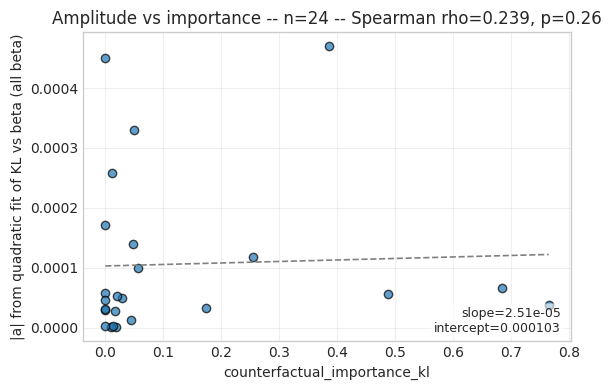

In [14]:
import numpy as np
from scipy.stats import spearmanr
from scipy.stats import spearmanr

# Fit quadratics to kl_curves_centered and scatter amplitude vs counterfactual_importance_kl
import matplotlib.pyplot as plt

# SciPy Spearman fallback handling (try reuse _have_scipy if present)
try:
    _have_scipy
except NameError:
    try:
        _have_scipy = True
    except Exception:
        _have_scipy = False

import numpy as np
import matplotlib.pyplot as plt
# Try SciPy for Spearman; fallback to rank+pearson if not available
try:
    from scipy.stats import spearmanr
    _have_scipy = True
except Exception:
    _have_scipy = False

eps_floats = np.array([float(e) for e in betas])
amplitudes = []
importances = []
for idx in range(len(chunks)):
    curve = kl_curves_centered.get(idx, None)
    if curve is None or len(curve) == 0:
        continue
    ys = np.array(curve, dtype=float)
    n = min(len(ys), len(eps_floats))
    x = eps_floats[:n]
    y = ys[:n]
    # Need at least 3 points to fit a quadratic robustly
    if x.size < 3 or np.all(np.isnan(y)):
        continue
    try:
        coeffs = np.polyfit(x, y, 2)  # returns [a, b, c]
        a = float(coeffs[0])
        amp = float(np.abs(a))
    except Exception:
        continue
    amplitudes.append(amp)
    # safe importance retrieval (fallback 0.0)
    try:
        imp = float(ex.get('counterfactual_importance_kl', [0.0]*len(chunks))[idx])
    except Exception:
        imp = 0.0
    importances.append(imp)

# Convert to arrays for plotting/statistics
x = np.array(importances)
y = np.array(amplitudes)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x, y, edgecolor='black', alpha=0.7)
ax.set_xlabel('counterfactual_importance_kl')
ax.set_ylabel('|a| from quadratic fit of KL vs beta (all beta)')

# Compute Spearman if available and meaningful
rho, pval = np.nan, np.nan
n_points = x.size
if n_points > 1:
    if _have_scipy:
        try:
            rho, pval = spearmanr(x, y)
        except Exception:
            rho, pval = np.nan, np.nan
    else:
        # fallback: compute ranks and Pearson on ranks
        def _ranks(arr):
            order = np.argsort(arr)
            ranks = np.empty_like(order, dtype=float)
            ranks[order] = np.arange(len(arr), dtype=float)
            return ranks
        try:
            rx = _ranks(x)
            ry = _ranks(y)
            if np.nanstd(rx) == 0 or np.nanstd(ry) == 0:
                rho, pval = np.nan, np.nan
            else:
                rho = float(np.corrcoef(rx, ry)[0,1])
                pval = np.nan
        except Exception:
            rho, pval = np.nan, np.nan

# Best-fit linear regression on (importance -> amplitude) for visualization
slope, intercept = np.nan, np.nan
if n_points > 1 and not np.allclose(x, x[0]):
    try:
        slope, intercept = np.polyfit(x, y, 1)
        xs_line = np.linspace(np.nanmin(x), np.nanmax(x), 200)
        ys_line = slope * xs_line + intercept
        ax.plot(xs_line, ys_line, color='gray', linestyle='--', linewidth=1.2, label=f'best-fit (slope={slope:.3g})')
    except Exception:
        slope, intercept = np.nan, np.nan

# Title and annotation
title = f'Amplitude vs importance -- n={n_points} -- Spearman rho={np.nan if np.isnan(rho) else float(rho):.3f}'
if not np.isnan(pval):
    title += f', p={float(pval):.3g}'
ax.set_title(title)
# Put fit stats on the plot
ann_lines = []
if not np.isnan(slope):
    ann_lines.append(f'slope={slope:.3g}')
if not np.isnan(intercept):
    ann_lines.append(f'intercept={intercept:.3g}')
if ann_lines:
    ax.text(0.98, 0.02, '\n'.join(ann_lines), transform=ax.transAxes, ha='right', va='bottom', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.6, edgecolor='none'))

# Print summary stats to the output as well
print(f'n_points={n_points}, spearman_rho={rho}, pval={pval}, slope={slope}, intercept={intercept}')

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
